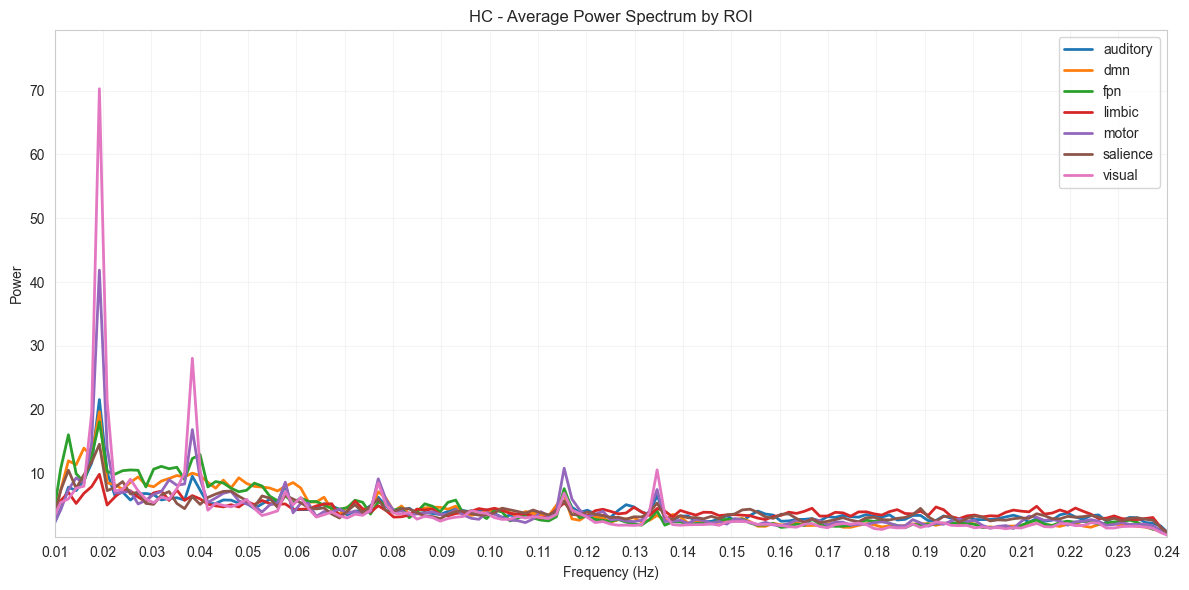

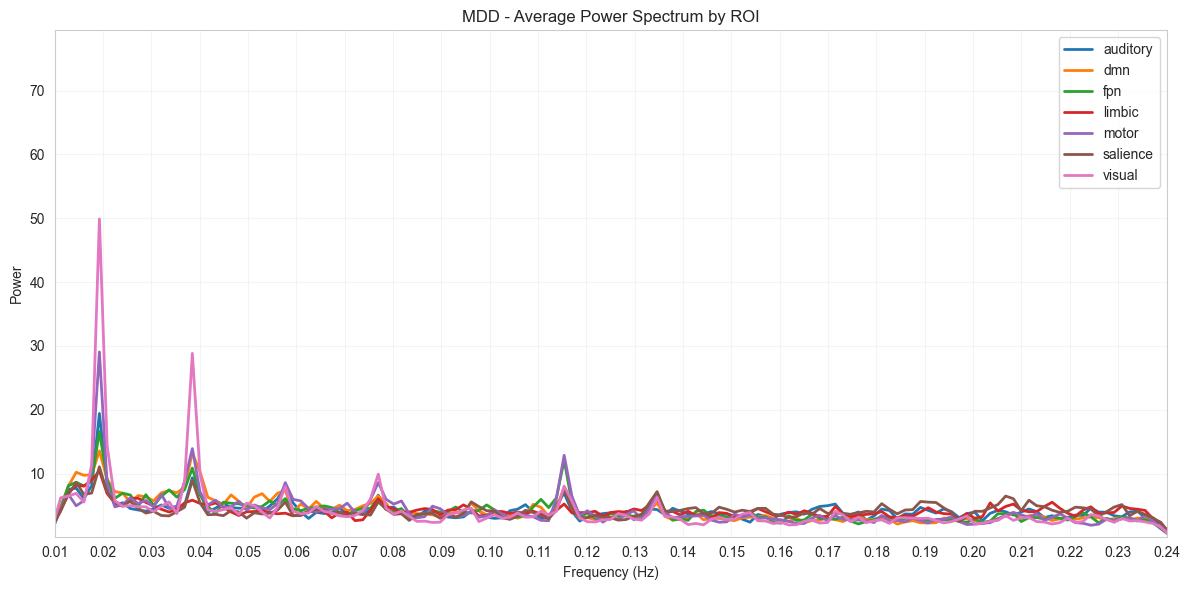

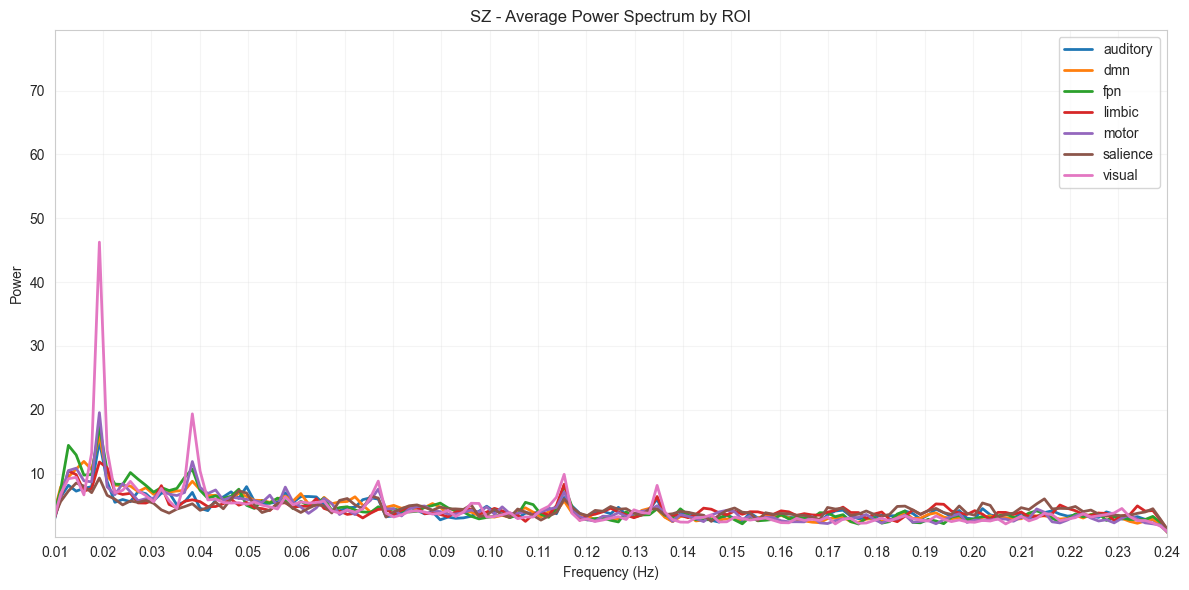

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Plot settings
PLOT_SETTINGS = {
    'x_min': 0.01,
    'x_max': 0.24,
    'y_min': 10**-1,
    'y_max': 10**1.9,
    'x_ticks_step': 0.01,
    'figsize': (12, 6)
}

# Group files
group_files = {
    'HC': 'psd_data_hc.csv',
    'MDD': 'psd_data_mdd.csv',
    'SZ': 'psd_data_sz.csv'
}

# Process each group
for group, file in group_files.items():
    # Create new figure for each group
    plt.figure(figsize=PLOT_SETTINGS['figsize'])
    sns.set_style('whitegrid')
    
    # Read the CSV file
    df = pd.read_csv(file)
    
    # Get frequency columns
    freq_cols = [col for col in df.columns if col.startswith('freq_')]
    frequencies = [float(col.split('_')[1]) for col in freq_cols]
    
    # Group by ROI and calculate mean power spectrum
    roi_means = df.groupby('roi')[freq_cols].mean()
    
    # Plot each ROI
    for roi in roi_means.index:
        plt.plot(frequencies, roi_means.loc[roi], label=roi, linewidth=2)
    
    # Set labels and title
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power')
    plt.title(f'{group} - Average Power Spectrum by ROI')
    
    # Set axis limits
    plt.xlim(PLOT_SETTINGS['x_min'], PLOT_SETTINGS['x_max'])
    plt.ylim(PLOT_SETTINGS['y_min'], PLOT_SETTINGS['y_max'])
    
    # Set x-ticks
    x_ticks = np.arange(PLOT_SETTINGS['x_min'], 
                        PLOT_SETTINGS['x_max'] + PLOT_SETTINGS['x_ticks_step'], 
                        PLOT_SETTINGS['x_ticks_step'])
    plt.xticks(x_ticks)
    
    # Add grid
    plt.grid(True, which="both", ls="-", alpha=0.2)
    
    # Add legend
    plt.legend()
    
    # Adjust layout
    plt.tight_layout()
    
    # Save the figure
    plt.savefig(f'psd_average_{group.lower()}.png', dpi=300, bbox_inches='tight')
    
    # Show the plot
    plt.show()
    
    # Close the figure to free memory
    plt.close()

## Compute PSD Group Stats

### Descriptive Stats
- Mean
- Std
- Median
- Min
- Max
- Skew
- Kurtosis

In [41]:
import os
import scipy.stats as stats

def compute_psd_stats(group_files, freq_band=(0.011218, 0.240385), output_dir='stats_output'):
    """
    Compute PSD statistics hierarchically: subject-level → group-level.
    Statistics are computed across the entire frequency spectrum for each ROI.
    
    Parameters:
    -----------
    group_files : dict
        Dictionary with group names as keys and file paths as values
    freq_band : tuple, optional
        Tuple of (min_freq, max_freq) to analyze specific frequency band
    output_dir : str, optional
        Directory to save intermediate results
    """
    os.makedirs(output_dir, exist_ok=True)
    stats_results = {}
    
    for group, file in group_files.items():
        # Read the CSV file
        df = pd.read_csv(file)
        
        # Get frequency columns and filter if needed
        freq_cols = [col for col in df.columns if col.startswith('freq_')]
        frequencies = [float(col.split('_')[1]) for col in freq_cols]
        
        if freq_band is not None:
            min_freq, max_freq = freq_band
            freq_mask = [(f >= min_freq) and (f <= max_freq) for f in frequencies]
            freq_cols = [col for col, mask in zip(freq_cols, freq_mask) if mask]
            
        # Step 1: Compute subject-level statistics
        subject_stats_list = []
        
        for subject in df['subject'].unique():
            subject_data = df[df['subject'] == subject]
            
            for roi in subject_data['roi'].unique():
                roi_data = subject_data[subject_data['roi'] == roi]
                
                # Compute statistics across ALL frequencies
                all_psd_values = roi_data[freq_cols].values.flatten()
                
                roi_stats = {
                    'subject': subject,
                    'roi': roi,
                    'mean': np.mean(all_psd_values),
                    'std': np.std(all_psd_values),
                    'median': np.median(all_psd_values),
                    'min': np.min(all_psd_values),
                    'max': np.max(all_psd_values),
                    'skew': stats.skew(all_psd_values),
                    'kurtosis': stats.kurtosis(all_psd_values)
                }
                
                subject_stats_list.append(roi_stats)
        
        # Convert to DataFrame
        subject_stats = pd.DataFrame(subject_stats_list)
        
        # Save subject-level checkpoint
        if freq_band is not None:
            subject_filename = f'{output_dir}/subject_stats_{group.lower()}_{min_freq}-{max_freq}Hz.csv'
        else:
            subject_filename = f'{output_dir}/subject_stats_{group.lower()}.csv'
        subject_stats.to_csv(subject_filename, index=False)
        
        # Step 2: Compute group-level statistics
        group_stats = subject_stats.groupby('roi').agg({
            'mean': ['mean', 'std', 'sem'],
            'std': ['mean', 'std', 'sem'],
            'median': ['mean', 'std', 'sem'],
            'min': ['mean', 'std', 'sem'],
            'max': ['mean', 'std', 'sem'],
            'skew': ['mean', 'std', 'sem'],
            'kurtosis': ['mean', 'std', 'sem']
        })
        
        # Save group-level results
        if freq_band is not None:
            group_filename = f'{output_dir}/group_stats_{group.lower()}_{min_freq}-{max_freq}Hz.csv'
        else:
            group_filename = f'{output_dir}/group_stats_{group.lower()}.csv'
        group_stats.to_csv(group_filename)
        
        stats_results[group] = group_stats

    return stats_results



In [44]:
freq_band_1 = (0.112179, 0.137821) # 10 % window
freq_band_2 = (0.027244, 0.035256) # 13 % window
full_spectrum = (0.011218, 0.240385)

stats_full_spectrum = compute_psd_stats(group_files, freq_band=full_spectrum)
stats_freq_band_1 = compute_psd_stats(group_files, freq_band=freq_band_1)
stats_freq_band_2 = compute_psd_stats(group_files, freq_band=freq_band_2)

In [45]:
def plot_power_distributions(group_files, freq_bands, output_dir='power_plots'):
    """
    Create boxplots of mean power for each frequency band across subjects.
    
    Parameters:
    -----------
    group_files : dict
        Dictionary with group names as keys and file paths as values
    freq_bands : dict
        Dictionary with band names as keys and (min_freq, max_freq) as values
    output_dir : str
        Directory to save the plots
    """
    os.makedirs(output_dir, exist_ok=True)
    
    # Initialize data storage
    plot_data = []
    
    for group, file in group_files.items():
        # Read the CSV file
        df = pd.read_csv(file)
        
        # Get frequency columns
        freq_cols = [col for col in df.columns if col.startswith('freq_')]
        frequencies = [float(col.split('_')[1]) for col in freq_cols]
        
        # Process each frequency band
        for band_name, (min_freq, max_freq) in freq_bands.items():
            # Select columns for this frequency band
            freq_mask = [(f >= min_freq) and (f <= max_freq) for f in frequencies]
            band_cols = [col for col, mask in zip(freq_cols, freq_mask) if mask]
            
            # Compute mean power for each subject and ROI
            for subject in df['subject'].unique():
                subject_data = df[df['subject'] == subject]
                
                for roi in subject_data['roi'].unique():
                    roi_data = subject_data[subject_data['roi'] == roi]
                    mean_power = roi_data[band_cols].values.mean()
                    
                    plot_data.append({
                        'Group': group,
                        'Subject': subject,
                        'ROI': roi,
                        'Band': band_name,
                        'Mean Power': mean_power
                    })
    
    # Convert to DataFrame
    plot_df = pd.DataFrame(plot_data)
    
    # Create plots
    plt.figure(figsize=(15, 10))
    sns.boxplot(data=plot_df, x='Band', y='Mean Power', hue='Group')
    sns.swarmplot(data=plot_df, x='Band', y='Mean Power', hue='Group', dodge=True, size=4, alpha=0.5)
    
    plt.title('Mean Power Distribution by Frequency Band and Group')
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Save plot
    plt.savefig(f'{output_dir}/power_distribution_all_bands.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # Create separate plots for each ROI
    for roi in plot_df['ROI'].unique():
        plt.figure(figsize=(15, 10))
        roi_data = plot_df[plot_df['ROI'] == roi]
        
        sns.boxplot(data=roi_data, x='Band', y='Mean Power', hue='Group')
        sns.swarmplot(data=roi_data, x='Band', y='Mean Power', hue='Group', dodge=True, size=4, alpha=0.5)
        
        plt.title(f'Mean Power Distribution by Frequency Band and Group - {roi}')
        plt.xticks(rotation=45)
        plt.tight_layout()
        
        plt.savefig(f'{output_dir}/power_distribution_{roi}.png', dpi=300, bbox_inches='tight')
        plt.close()

# Example usage:
FREQ_BANDS = {
    'Task_1': (0.112179, 0.137821),  # 10% window
    'Task_2': (0.027244, 0.035256),  # 13% window
    # 'Low': (0.011218, 0.027244),
    # 'Mid': (0.035256, 0.112179),
    # 'High': (0.137821, 0.240385)
}

plot_power_distributions(group_files, FREQ_BANDS, output_dir='power_plots')